# Inverse Kinematics tutorial

we'll demonstrate inverse kinematics on a baxter robot

## Setup

In [1]:
import numpy as np
from pykin.robots.bimanual import Bimanual
from pykin.kinematics.transform import Transform
from pykin.utils import plot_utils as plt
from pykin.utils.transform_utils import compute_pose_error

In [2]:
file_path = '../asset/urdf/baxter/baxter.urdf'

robot = Bimanual(file_path, Transform(rot=[0.0, 0.0, 0.0], pos=[0, 0, 0]))
visible_collision = True

You must set from base link name to end effector link name

In [3]:
robot.setup_link_name("base", "right_wrist")
robot.setup_link_name("base", "left_wrist")

In [4]:
# set the angles you want
head_thetas =  np.zeros(1)
right_arm_thetas = np.array([-np.pi/4 , 0, 0, 0, 0 , 0 ,0])
left_arm_thetas = np.array([np.pi/4 , 0, 0, 0, 0 , 0 ,0])

### Compute the forward kinematics to set the robot's target pose.

In [5]:
thetas = np.concatenate((head_thetas ,right_arm_thetas ,left_arm_thetas))
target_transformations = robot.forward_kin(thetas)

In [6]:
fig, ax = plt.init_3d_figure()
plt.plot_robot(robot, 
               ax=ax,
               transformations=target_transformations, 
               visible_collision=visible_collision)
ax.legend()

## Compute Inverse Kinematics

First, you must set joint initial angles using np.random.randn

In [7]:
init_thetas = np.random.randn(7)

### Get the target pose with the target transformations information obtained above.

In [8]:
target_pose = { "right": robot.get_eef_pose(target_transformations)["right"], 
                "left" : robot.get_eef_pose(target_transformations)["left"]}
print(target_pose)

{'right': array([ 0.06402554, -1.18271238,  0.320976  ,  0.49999954,  0.50000046,
        0.49999954, -0.50000046]), 'left': array([ 0.06402554,  1.18271238,  0.320976  ,  0.49999954, -0.50000046,
        0.49999954,  0.50000046])}


Target pose's shape for Inverse Kinematics is (7,)

Combine position(x,y,z) and orientation(quaternion: w,x,y,z)

### Compute the target joint using inverse kinematics.

Iterators is the number of iterations to update the joint angle.

WorkingTime is how long this function takes to execute.

LM means to levenberg-marquardt and NR means to Newton Raphson.

### levenberg-marquardt Method

In [9]:
ik_LM_result = robot.inverse_kin(
    init_thetas, 
    target_pose, 
    method="LM", 
    max_iter=100)
print(ik_LM_result)

Iterators : 100
WorkingTime[inverse_kinematics]: 0.0821 sec

Iterators : 100
WorkingTime[inverse_kinematics]: 0.0783 sec

{'right': array([-0.79011491,  0.01322305, -0.0743274 , -0.01308284,  1.13137846,
        0.00331324, -1.05709728]), 'left': array([ 0.79036882,  0.00431996, -0.15936087,  0.00138095,  0.94747849,
       -0.00730921, -0.78811803])}


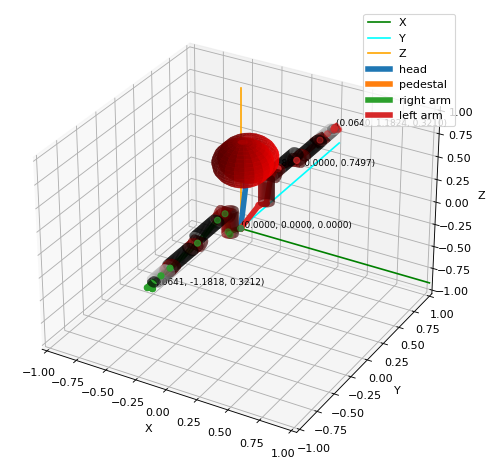

In [10]:
thetas_LM = np.concatenate((head_thetas, ik_LM_result["right"], ik_LM_result["left"]))
result_fk_LM = robot.forward_kin(thetas_LM)
_, ax = plt.init_3d_figure("LM IK Result")
plt.plot_robot(robot, ax, result_fk_LM, visible_collision=visible_collision)

### Newton Raphson method

In [11]:
ik_NR_result = robot.inverse_kin(
    init_thetas, 
    target_pose, 
    method="NR", 
    max_iter=100)
print(ik_NR_result)

Iterators : 26
WorkingTime[inverse_kinematics]: 0.0238 sec

Iterators : 25
WorkingTime[inverse_kinematics]: 0.0225 sec

{'right': array([-7.70076915e-01, -2.19307223e-04, -2.59493832e-01,  1.38596351e-02,
        9.88435182e-01, -1.76643479e-02, -7.28840818e-01]), 'left': array([ 0.81073192,  0.00152706, -0.37064946,  0.01851416,  1.15200836,
       -0.02645325, -0.78111586])}


In [12]:
thetas_NR = np.concatenate((head_thetas, ik_NR_result["right"], ik_NR_result["left"]))
result_fk_NR = robot.forward_kin(thetas_NR)
_, ax = plt.init_3d_figure("NR IK Result")
plt.plot_robot(robot, ax, result_fk_NR, visible_collision=visible_collision)

### Error between target pose and pose obtained by solving ik

In [13]:
err = {}
for arm in robot.arm_type:
    err[arm+"_NR_error"] = compute_pose_error(
        target_transformations[robot.eef_name[arm]].h_mat,
        result_fk_NR[robot.eef_name[arm]].h_mat)

    err[arm+"_LM_error"] = compute_pose_error(
        target_transformations[robot.eef_name[arm]].h_mat,
        result_fk_LM[robot.eef_name[arm]].h_mat)

for error_name, value in err.items():
    print(f"{error_name} : {value}")

plt.show_figure()

right_NR_error : 6.824553521976666e-07
right_LM_error : 0.004120571633883305
left_NR_error : 8.743632721585448e-07
left_LM_error : 0.0013794640451243918
